### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [78]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


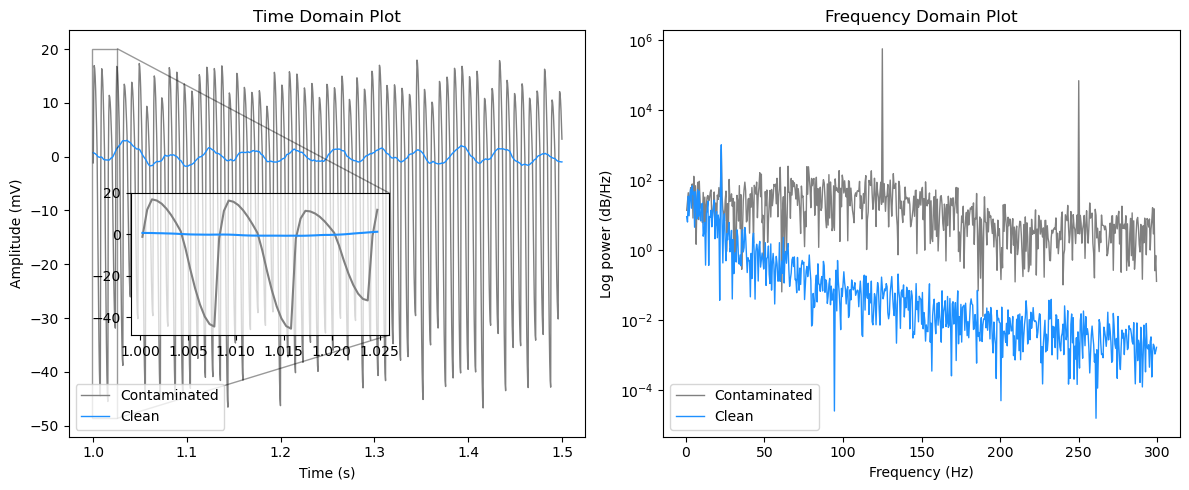

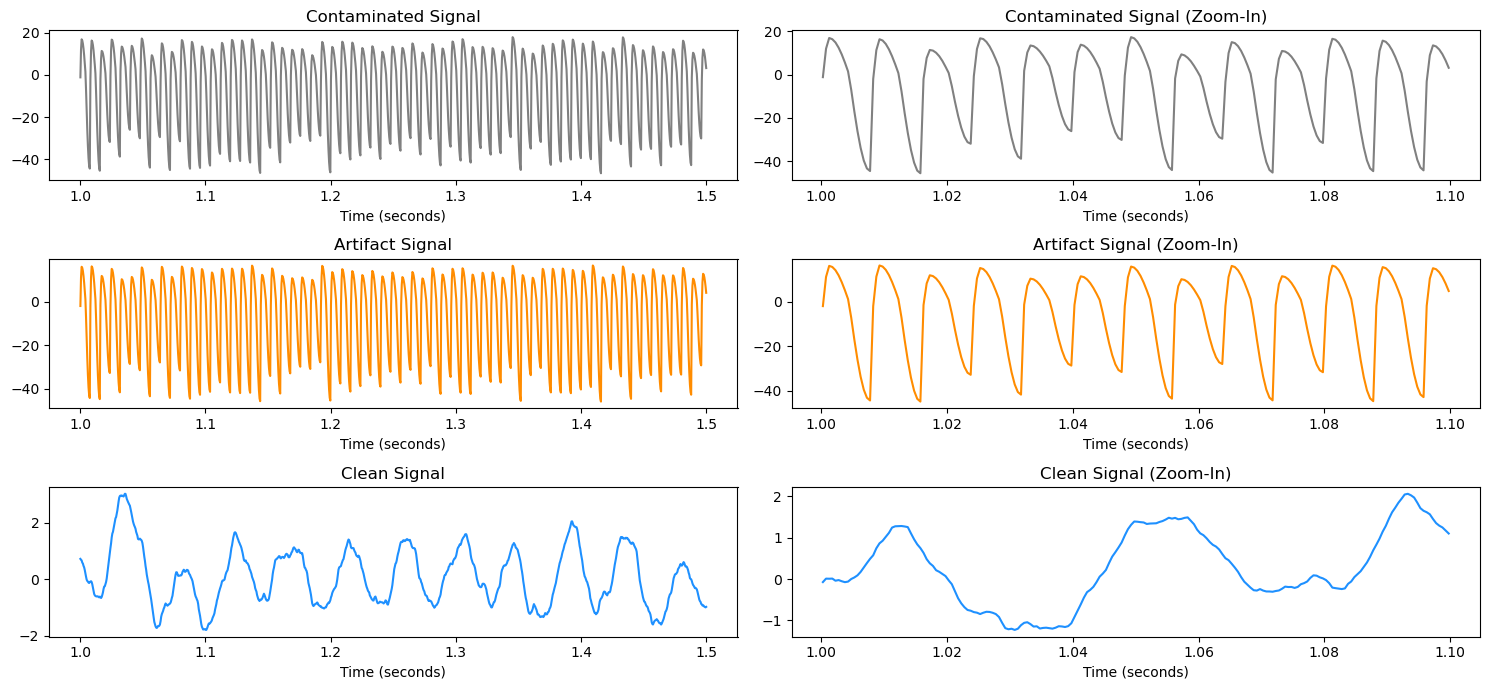

In [79]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [80]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [81]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000, 1)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000, 1)
-----------------------------


In [82]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)
        self.drop = nn.Dropout(0.25)
        self.gelu = nn.GELU()

    def forward(self, input_data): # x : B x T x 1
        x = self.gelu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = self.gelu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = self.gelu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [83]:
# 모델 인스턴스 생성
model = MLP().to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [84]:
# 모델 학습
num_epochs = 500

loss_list = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')


Epoch [5/500] | Loss: 0.004662208687514067
Epoch [10/500] | Loss: 0.004185172729194164
Epoch [15/500] | Loss: 0.0039212781935930256
Epoch [20/500] | Loss: 0.0037488340493291618
Epoch [25/500] | Loss: 0.00362252133898437
Epoch [30/500] | Loss: 0.003524924023076892
Epoch [35/500] | Loss: 0.003449237607419491
Epoch [40/500] | Loss: 0.0033817560691386463
Epoch [45/500] | Loss: 0.0033214193023741244
Epoch [50/500] | Loss: 0.00326844428665936
Epoch [55/500] | Loss: 0.003219366492703557
Epoch [60/500] | Loss: 0.003174070743843913
Epoch [65/500] | Loss: 0.0031317667849361896
Epoch [70/500] | Loss: 0.003091007461771369
Epoch [75/500] | Loss: 0.00305411359295249
Epoch [80/500] | Loss: 0.0030208837892860174
Epoch [85/500] | Loss: 0.002990470575168729
Epoch [90/500] | Loss: 0.002963524041697383
Epoch [95/500] | Loss: 0.0029386542178690433
Epoch [100/500] | Loss: 0.00291608389467001
Epoch [105/500] | Loss: 0.002899284791201353
Epoch [110/500] | Loss: 0.002883205451071262
Epoch [115/500] | Loss: 0.0

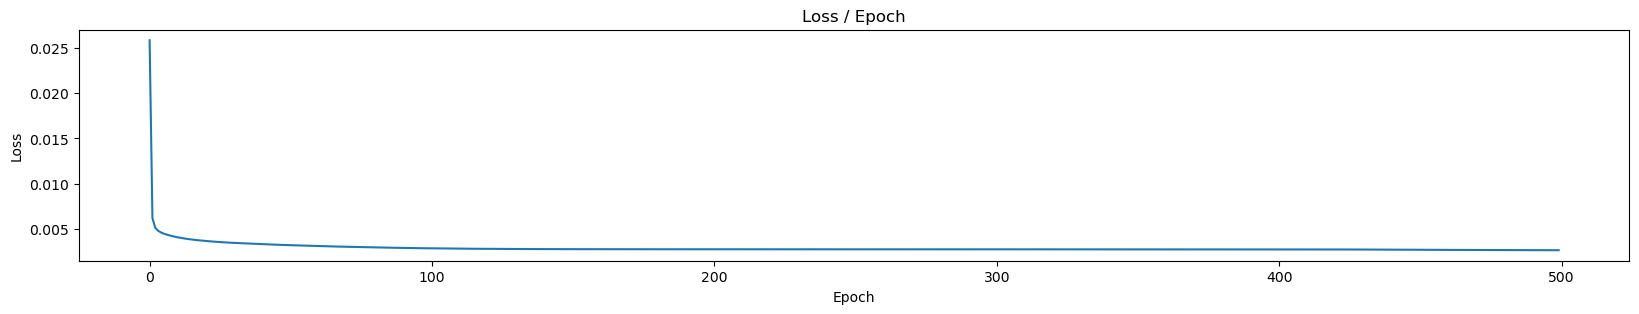

Minimal Loss: 0.002706640027463436 [499]



In [85]:
# Train Loss Plot
Loss_Plot(loss_list)

In [86]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')

Test Loss: 0.002678294712677598


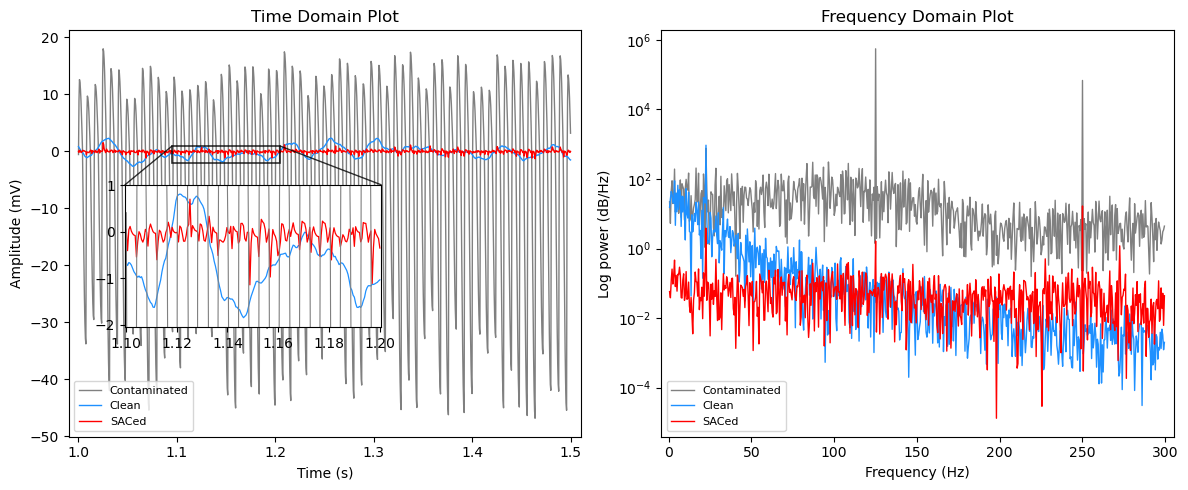

<Time Domain Error>
Mean Absolute Error: 0.7759
Mean Squared Error: 0.9266
<Frequency Domain Error>
Mean Absolute Error: 2.0551
Mean Squared Error: 2041.4208


In [87]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
save_path = '../../../../result/MLP/'
save_title = 'MLP_IO_time_L_time'

Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled, save_path, save_title) # inverse scaled data를 input으로 넣음